<a href="https://colab.research.google.com/github/Gu-ddy/ECG_ML_project/blob/main/BSc_Thesis_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description:
The objective of this work is to compare performances of RNN (LSTM based) and classical time series statistical model ARIMA in a stock price prediction task (FTSEMIB). The impact of differentiation, multi horizon and external data (S&P and DAX) was also explored.

# 0.   Importazione di pacchetti e definizione di funzioni

## Librerie

In [ ]:
#! pip3 uninstall statsmodels
#! pip3 install numpy scipy patsy pandas
from tensorflow.random import set_seed
set_seed(89)

from numpy.random import seed
seed(7)


from random import seed as seed1
seed1(8)
! pip3 install statsmodels
!pip install pmdarima

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow import concat
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler
from pandas import Series
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D,GlobalMaxPooling1D, LSTM
from tensorflow.keras.layers import Dense, Flatten, Dropout, Concatenate, AveragePooling1D
from tensorflow.keras.layers import InputLayer, Input, ActivityRegularization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 3.2 MB/s 
     |████████████████████████████████| 9.8 MB 33.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## Funzioni

In [ ]:
def replace(s,x,y):
  return s.replace(x,y)

def data_to_supervised (dati_X,dati_y,n_timestamps,n_outputs):
  '''
  Restituisce due array: X e y tramite i quali si può allenare una rete neurale ricorrente.
  L'i-esimo elemento di X sarà un array di forma (n_timestamp, numero di predittori). L'i-esimo elemento di y conterrà il corrispondente
  valore della variabile target, ossia un array di n_output valori della variabile da voler predirre nel tempo. In altre parole X conterrà
  gli array di dati che si vuole utilizzare per predirre gli omologhi elementi di y.

  Notiamo che se si vogliono usare n_timestamp giorni precedenti per predirne n_output, la lunghezza di X e y sarà data da:
  Numero di osservazioni in dati_X (o dati_y) - n_timestamps - n_outputs +1

  UN ESEMPIO ILLUSTRATIVO DELLA FUNZIONE SI PUO TROVARE COME PRIMO PARAGRAFO DELLA SEZIONE RNN MODEL


  Dati_X è il dataframe contenete le variabili da usare come predittori (tra cui sarà sicuramente presente la chiusura del FTSEMIB)
  Dati_y conterrà la variabile target (nel nostro caso le chiusure del FTSEMIB)
  A partire da dati_X e da dati_y si creano l'array dei predittori X e l'array della variabile target y.
  n_output definisce l'orizzonte della predizione, quanti istanti futuri si vuole predirre.
  n_timestamps definisce il numero di istanti precedenti al primo da voler predirre che si useranno come input.
  Esempio:
  Dati_X=Chiusure del FTSEMIB, Dati_y=Chiusure del FTSEMIB, n_output=2, n_timestamps=3.
  Useremo i valori delle chiusure del FTSEMIB nei giorni t-1, t-2 e t-3 per predirre i valori delle chiusure del FTSEMIB dei giorni t,t+1.
  '''
  n_samples=dati_X.shape[0]-n_timestamps-n_outputs+1
  n_features=dati_X.shape[1]

  X=np.zeros((n_samples,n_timestamps,n_features))
  for s in range(n_samples):
    for t in range(n_timestamps):
      for f in range(n_features):
        X[s,t,f]=dati_X.iloc[s+t,f]

  y=np.zeros((n_samples,n_outputs))
  for s in range(n_samples):
    for o in range(n_outputs):
      y[s,o]=dati_y.iloc[s+n_timestamps+o]
  return X,y





def previsione_arima(serie,inizio,n_output,order,params):
  '''Utilizza un modello ARIMA di ordine pari a order e con coefficienti pari a params per predirre gli n_output
  valori successivi all'inizio-esimo della serie.
  I valori della serie fino all'inizio-esimo sono usati come input ma non per stimare i coefficienti, che sono fissati
  come argomento della funzione insieme all'ordine del modello.
   '''
  mod=ARIMA(serie[:inizio],order=order) # diamo l'ordine e facciamo conoscere al modello la serie fino ai primi inzio valori.
  f1=mod.fit_constrained(param) #fissiamo i coefficienti
  return f1.forecast(n_output)

def previsioni_arima(serie,inizio,n_output,order,params):
  '''Utilizza previsione_arima per predirre tutti i possibili blocchi di n_output predizioni che si possono creare da serie partendo
  dalla conoscenza di serie[:inizio] e incrementando di un giorno la conoscenza della serie per il blocco di predizione successivo.
 Esempio:
 serie=[90,85,82,87,91,75,98,100,111], inizio= 2,order=(2,0,0), params= [0.6,0.4], n_output=3

 si usa un modello ARIMA (2,0,0) con coefficienti= [0.6,0.4]
 1)Al modello si fa conoscere la serie [90,85] e lo si usa per predirre i 3 giorni successivi (il cui valore vero sarebbe 82,87,91)
 2)Al modello si fa conoscere la serie [90,85,82] e lo si usa per predirre i 3 giorni successivi (il cui valore vero sarebbe 87,91,75)
 3)Al modello si fa conoscere la serie [90,85,82,87] e lo si usa per predirre i 3 giorni successivi (il cui valore vero sarebbe 91,75,98)
 e così via...

  '''
  prev=np.zeros(shape=(len(serie)-n_output-N_train+1,n_output))
  for i in range(len(serie)-n_output-N_train+1):
    p=previsione_arima(serie,inizio+i,n_output,order,params)
    prev[i,:]=p
  return prev


def diff_to_value(diff_pred, origini):
  pred=np.zeros(shape=diff_pred.shape)
  for i in range(diff_pred.shape[0]):
    for j in  range(diff_pred.shape[1]):
      pred[i,j]

## Setting Graphics parameters

In [ ]:
sns.set(rc={'figure.figsize':(22.7,11.27)})
sns.set_style("whitegrid")
#pd.options.display.float_format='{:.2f}'.format

# Caricamento e pulizia dei dati

Carichiamo i dati del FTSEMIB, del DAX e dello S&P500.

In [ ]:
ftsemib=pd.read_csv('/content/drive/MyDrive/Tesi Triennale/FTSEMIB.csv')
dax=pd.read_csv('/content/drive/MyDrive/Tesi Triennale/DAX.csv')
sp=pd.read_csv('/content/drive/MyDrive/Tesi Triennale/S&P.csv')

Possiamo osservare che sono presenti meno osservazione riguardanti gli indici esteri.

In [ ]:
print('n osservazioni: \nFTSEMIB: {}\nS&P: {}\nDAX: {}'.format(ftsemib.shape[0],sp.shape[0],dax.shape[0]))

n osservazioni: 
FTSEMIB: 2537
S&P: 2516
DAX: 2529


Notiamo che le date sono state codificate come objects.

In [ ]:
print(ftsemib.dtypes[0],dax.dtypes[0],sp.dtypes[0])

object object object


Controlliamo il formato con cui sono registrate le date.

In [ ]:
print('Prima osservazione registrata:\nFTSEMIB: {} \nS&P: {}\nDAX: {}'.format(ftsemib.DATA[0],sp.DATA[0],dax.DATA[0]))

Prima osservazione registrata:
FTSEMIB: 03/11/11 
S&P: 03/11/11
DAX: 03/11/11


Convertiamo ora le date degli indici in datetime.

In [ ]:
ftsemib['DATA']=pd.to_datetime(ftsemib['DATA'],format='%d/%m/%y')
dax['DATA']=pd.to_datetime(dax['DATA'],format='%d/%m/%y')
sp['DATA']=pd.to_datetime(sp['DATA'],format='%d/%m/%y')

Indicizziamo i dataframe grazie alle date e rimuoviamole come variabili nei dataframe.

Manterremo inoltre unicamente le informazioni riguardanti le chiusure del DAX e le aperture dello S&P.

In [ ]:
ftsemib.index=ftsemib.DATA
dax.index=dax.DATA
sp.index=sp.DATA

ftsemib.drop('DATA',axis=1,inplace=True)
dax=dax.iloc[:,4]
sp=sp.iloc[:,1]


Avendo l'obiettivo di voler predirre l'indice del FTSEMIB useremo unicamente le date per cui si hanno rilevazioni su questo.

Tuttavia per alcune di queste non si hanno informazioni relative agli altri due indici.

Riguardo queste (le date in cui si hanno informazioni sul FTSEMIB ma non su DAX o S&P) assegneremo come valore di chiusura o di apertura degli indici esteri quello del giorno passato più vicino alla data considerata.

**Esempio:**

Non si possiede l'informazione della apertura dello S&P del 20 Ottobre 2015. Inseriremo come valore per quella data il valore registrato il 19 ottobre (se esiste, altrimenti quello del 18 e così via...)


In [ ]:
def previous(day,serie):
  while 1:
    day=day-pd.Timedelta(1,'day')
    if day in serie.index:
      return serie[day]

In [ ]:
for day in ftsemib.index:
  if day not in dax.index:
    dax[day]=previous(day,dax)

for day in ftsemib.index:
  if day not in sp.index:
    sp[day]=previous(day,sp)

Grazie a queste modifiche possiamo adesso unire i tre dataframe.

In [ ]:
dati_completi=ftsemib.join(dax,rsuffix='_DAX')
dati_completi=dati_completi.join(sp,rsuffix='_SP')
dati_completi.head(4)

,APERTURA,MASSIMO,MINIMO,CHIUSURA,VAR % CLOSE,VOLUME,CHIUSURA_DAX,APERTURA_SP
DATA,,,,,,,,
2011-11-03,"14.904,32","15.983,70","14.884,74","15.766,16","0,00",1295687802,"6.133,20","1.238,25"
2011-11-04,"15.890,08","16.014,36","15.210,73","15.346,55","-2,66",1028623546,"5.966,15","1.260,82"
2011-11-07,"15.187,85","15.822,69","14.937,09","15.548,94","1,32",1073642958,"5.928,70","1.253,21"
2011-11-08,"15.600,96","16.023,41","15.564,02","15.664,06","0,74",897599022,"5.961,45","1.261,12"


## Pulizia: Le variabili sono state codificate come qualitative

Osserviamo come tutte le variabili al di fuori del volume siano state codificate come objects.

In [ ]:
dati_completi.dtypes

APERTURA        object
MASSIMO         object
MINIMO          object
CHIUSURA        object
VAR % CLOSE     object
VOLUME           int64
CHIUSURA_DAX    object
APERTURA_SP     object
dtype: object

In [ ]:
dati_completi.head(3)

,APERTURA,MASSIMO,MINIMO,CHIUSURA,VAR % CLOSE,VOLUME,CHIUSURA_DAX,APERTURA_SP
DATA,,,,,,,,
2011-11-03,"14.904,32","15.983,70","14.884,74","15.766,16","0,00",1295687802,"6.133,20","1.238,25"
2011-11-04,"15.890,08","16.014,36","15.210,73","15.346,55","-2,66",1028623546,"5.966,15","1.260,82"
2011-11-07,"15.187,85","15.822,69","14.937,09","15.548,94","1,32",1073642958,"5.928,70","1.253,21"


Trasformiamole dunque in modo da poterle rendere floats.

In [ ]:
for i in range(dati_completi.shape[1]):
  if i!=5: dati_completi.iloc[:,i]=dati_completi.iloc[:,i].apply(replace,x='.',y='').apply(replace,x=',',y='.').astype('float64')
dati_completi.dtypes

APERTURA        float64
MASSIMO         float64
MINIMO          float64
CHIUSURA        float64
VAR % CLOSE     float64
VOLUME            int64
CHIUSURA_DAX    float64
APERTURA_SP     float64
dtype: object

## Feature Engineering: Range

Definiamo la variabile range come la differenza tra la il massimo e il minimo valore del FTSEMIB in quella giornata. È logico pensare che tale informazione, sintetizzando la volatilità del titolo, possa essere utile per le previsioni.

In [ ]:
dati_completi['RANGE']=dati_completi['MASSIMO']-dati_completi['MINIMO']

Creiamo anche i dati differenziati

In [ ]:
dati_completi['DIFFERENZE PRIME']=dati_completi.CHIUSURA.diff()

## Visualizzazione dei principali indici di sintesi per ogni variabile e visualizzazione della Serie dei valori dell'indice in chiusura

In [ ]:
dati_completi.describe()

,APERTURA,MASSIMO,MINIMO,CHIUSURA,VAR % CLOSE,VOLUME,CHIUSURA_DAX,APERTURA_SP,RANGE,DIFFERENZE PRIME
count,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2.537000e+03,2537.000000,2537.000000,2537.000000,2536.000000
mean,19976.248703,20130.168143,19804.288912,19968.741892,0.033197,6.334601e+08,10868.828616,2417.199669,325.879231,4.578750
std,3036.059081,3019.601165,3051.415794,3039.446741,1.500067,2.909760e+08,2385.582289,793.160668,181.364964,282.640074
min,12357.700000,12656.380000,12295.760000,12362.510000,-16.920000,1.483866e+08,5428.100000,1158.670000,85.090000,-3034.200000
25%,17413.490000,17587.350000,17237.100000,17431.170000,-0.690000,4.119858e+08,9377.200000,1875.270000,212.670000,-137.175000
50%,20299.100000,20463.340000,20157.420000,20324.230000,0.070000,5.704865e+08,11130.200000,2182.240000,286.320000,14.635000
75%,22194.410000,22324.770000,21999.890000,22169.420000,0.820000,7.992666e+08,12543.900000,2861.510000,389.210000,165.992500
max,27172.870000,27377.870000,27140.650000,27377.870000,8.930000,2.676921e+09,15977.450000,4627.300000,2765.420000,1388.800000


Andiamo a visualizzare la serie dei valori dell'indice in chiusura, ossia l'oggetto di predizione.

Text(0.5, 1.0, 'Valore del FTSEMIB in chiusura')

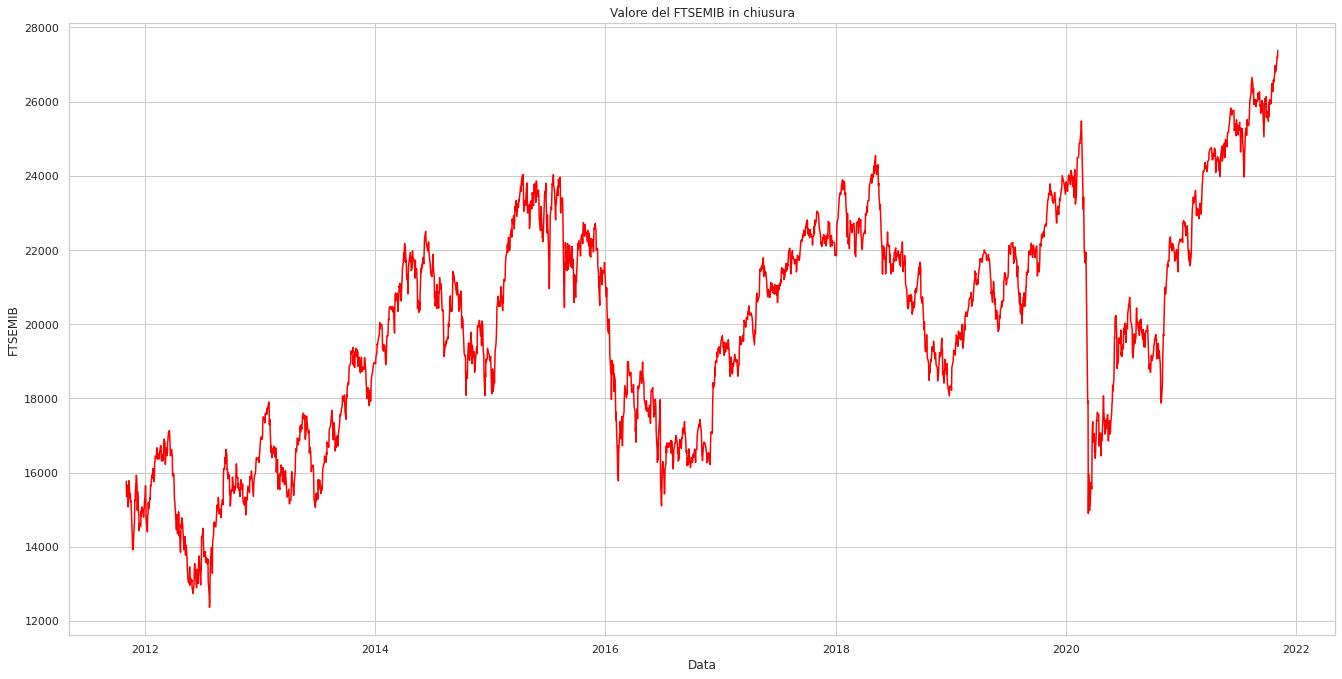

In [ ]:
y=dati_completi.CHIUSURA
x=dati_completi.index
p=sns.lineplot(x,y,color='red')
p.set_xlabel('Data')
p.set_ylabel('FTSEMIB')
p.set_title('Valore del FTSEMIB in chiusura')

# RNN DATI NON DIFFERENZIATI

In [ ]:
N=dati_completi.shape[0]
N_train=int(0.8*N)
n_output=10
n_timestamps=20

dati_y=dati_completi.iloc[:,3] #variabile target (la chiusura del FTSEMIB)
dati_X=dati_completi.iloc[:,[3]]


#Standardizziamo i dati utilizzando solo le osservazioni riservate all'addestramento
mu=dati_X[:N_train].mean()
sd=dati_X[:N_train].std()


#Dataframe dei predittori standardizzato
dati_X_sd=(dati_X-mu)/sd

X,y=data_to_supervised(dati_X_sd,dati_y,n_timestamps=n_timestamps,n_outputs=n_output)

X_train,y_train=X[:N_train-n_timestamps-n_output+1,:,:],y[:N_train-n_timestamps-n_output+1,:]

In [ ]:
input1 = Input(shape = (n_timestamps,dati_X.shape[1]))

# Layer LSTM sull'intero mese
z0 = LSTM(64,kernel_regularizer=regularizers.l2(0.001))(input1)

# Layer LSTM sulle medie settimanali
z1 = AveragePooling1D(pool_size=5, strides=5, padding='valid')(input1)
z1 = LSTM(32,kernel_regularizer=regularizers.l2(0.001))(z1)

# Layer LSTM sulle medie bisettimanali
z2 = AveragePooling1D(pool_size=10, strides=10, padding='valid')(input1)
z2 = LSTM(32,kernel_regularizer=regularizers.l2(0.001))(z2)

# Layer LSTM sulle medie trisettimanali
z3 = AveragePooling1D(pool_size=20, strides=15, padding='valid')(input1)
z3 = LSTM(32,kernel_regularizer=regularizers.l2(0.001))(z3)

# Valori medi delle variabili
z5 = GlobalAveragePooling1D()(input1)
z5 = Dense(16,activation='elu')(z5)

#Valori massimi delle variabili
z6 = GlobalMaxPooling1D()(input1)
z6 = Dense(16,activation='elu')(z6)

x = Concatenate()([z0,z1,z2,z3,z5,z6])
x = Dense(1024, activation = 'hard_sigmoid')(x)
x = Dropout(0.2,seed=12345)(x)

z = Dense(n_output, activation = "linear")(x)

output=Dense(n_output)(z)
model = Model(inputs=[input1], outputs=output)


optimizer = keras.optimizers.SGD(lr=3e-8)
model.compile(optimizer = optimizer , loss = "mse", metrics=["mae"])

In [ ]:
model.fit(X_train,
y_train,
epochs=200,
batch_size=256,
verbose=1)

Epoch 1/200
8/8 [==============================] - 8s 66ms/step - loss: 384780128.0000 - mae: 19424.3496
Epoch 2/200
8/8 [==============================] - 1s 64ms/step - loss: 384773088.0000 - mae: 19424.1680
Epoch 3/200
8/8 [==============================] - 1s 65ms/step - loss: 384765920.0000 - mae: 19423.9844
Epoch 4/200
8/8 [==============================] - 1s 66ms/step - loss: 384758880.0000 - mae: 19423.8008
Epoch 5/200
8/8 [==============================] - 1s 64ms/step - loss: 384751200.0000 - mae: 19423.6035
Epoch 6/200
8/8 [==============================] - 1s 68ms/step - loss: 384743648.0000 - mae: 19423.4082
Epoch 7/200
8/8 [==============================] - 1s 64ms/step - loss: 384735456.0000 - mae: 19423.1953
Epoch 8/200
8/8 [==============================] - 1s 67ms/step - loss: 384726976.0000 - mae: 19422.9805
Epoch 9/200
8/8 [==============================] - 1s 64ms/step - loss: 384718272.0000 - mae: 19422.7559
Epoch 10/200
8/8 [==============================] - 1s 

In [ ]:
X_test,y_test=X[N_train-n_timestamps:,:,:],y[N_train-n_timestamps:,:]
y_hat_rnn_1=model.predict(X_test)
mae_rnn_1=mae(y_hat_rnn_1,y_test)
mae_rnn_1

1577.3892386491743

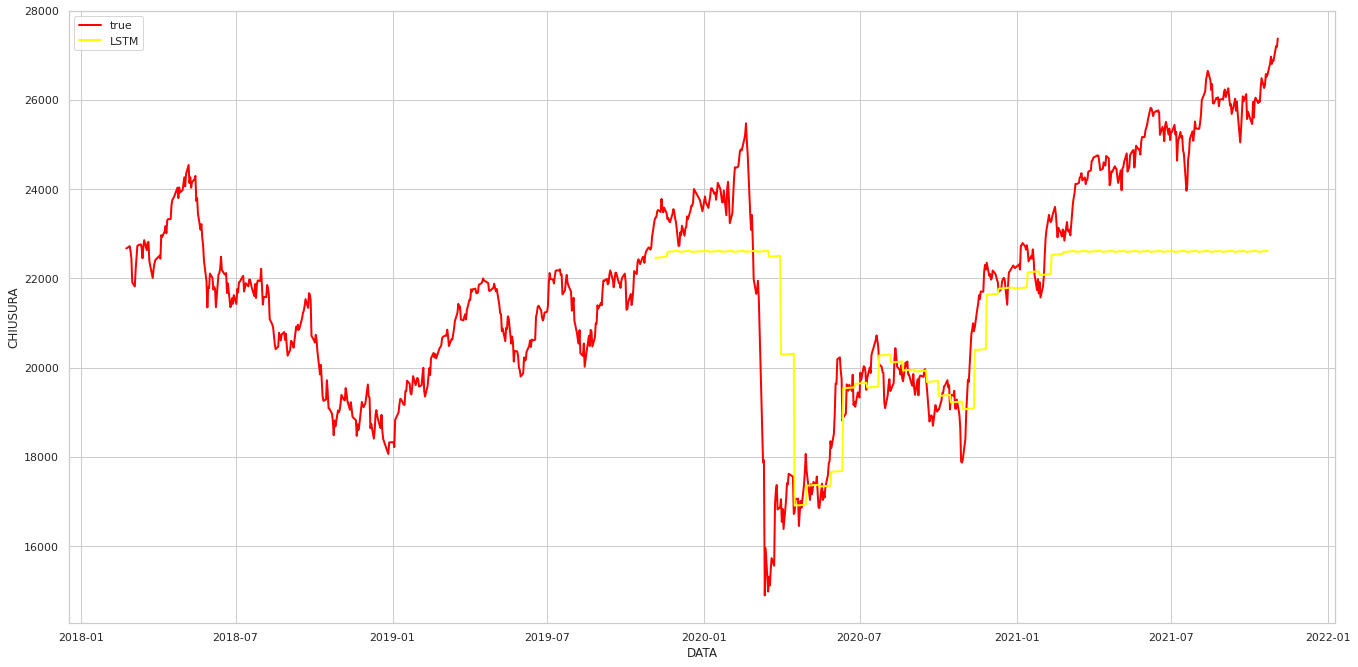

In [ ]:
y_prev_rnn_1=[]

i=0
while i<y_hat_rnn_1.shape[0]:
  p=y_hat_rnn_1[i,:]
  i+=n_output
  for z in p:
    y_prev_rnn_1.append(z)
y=dati_completi.CHIUSURA
x=dati_completi.index
x_prev=dati_completi.index[N_train:-(dati_completi.shape[0]-N_train-len(y_prev_rnn_1))]
p=sns.lineplot(x[1600:],y[1600:],color='red',lw=2,label='true')
p=sns.lineplot(x_prev,y_prev_rnn_1,color='yellow',lw=2,label='LSTM')


# RNN DATI DIFFERENZIATI

In [ ]:
dati_completi=dati_completi.drop(dati_completi.index[0],axis=0)
N=dati_completi.shape[0]
N_train=int(0.8*N)
n_output=10
n_timestamps=20

dati_y=dati_completi.iloc[:,9] #variabile target (la chiusura del FTSEMIB)
dati_X=dati_completi.iloc[:,[9]]


#Standardizziamo i dati utilizzando solo le osservazioni riservate all'addestramento
mu=dati_X[:N_train].mean()
sd=dati_X[:N_train].std()


#Dataframe dei predittori standardizzato
dati_X_sd=(dati_X-mu)/sd

X,y=data_to_supervised(dati_X_sd,dati_y,n_timestamps=n_timestamps,n_outputs=n_output)

X_train,y_train=X[:N_train-n_timestamps-n_output+1,:,:],y[:N_train-n_timestamps-n_output+1,:]

In [ ]:
def diff_to_value(diff_pred,inizio=N_train-1):
  pred=np.zeros(shape=diff_pred.shape)
  for i in range(diff_pred.shape[0]):
    origine=dati_completi['CHIUSURA'][inizio]
    inizio+=1
    for j in range(diff_pred.shape[1]):
      pred[i,j]=origine+diff_pred[i,j]
      origine=pred[i,j]
  return pred

In [ ]:
input1 = Input(shape = (n_timestamps,dati_X.shape[1]))

# Layer LSTM sull'intero mese
z0 = LSTM(64,kernel_regularizer=regularizers.l2(0.001))(input1)

# Layer LSTM sulle medie settimanali
z1 = AveragePooling1D(pool_size=5, strides=5, padding='valid')(input1)
z1 = LSTM(32,kernel_regularizer=regularizers.l2(0.001))(z1)

# Layer LSTM sulle medie bisettimanali
z2 = AveragePooling1D(pool_size=10, strides=10, padding='valid')(input1)
z2 = LSTM(32,kernel_regularizer=regularizers.l2(0.001))(z2)

# Layer LSTM sulle medie trisettimanali
z3 = AveragePooling1D(pool_size=20, strides=15, padding='valid')(input1)
z3 = LSTM(32,kernel_regularizer=regularizers.l2(0.001))(z3)

# Valori medi delle variabili
z5 = GlobalAveragePooling1D()(input1)
z5 = Dense(16,activation='elu')(z5)

#Valori massimi delle variabili
z6 = GlobalMaxPooling1D()(input1)
z6 = Dense(16,activation='elu')(z6)

x = Concatenate()([z0,z1,z2,z3,z5,z6])
x = Dense(1024, activation = 'hard_sigmoid')(x)
x = Dropout(0.2,seed=12345)(x)

z = Dense(n_output, activation = "linear")(x)

output=Dense(n_output)(z)
model = Model(inputs=[input1], outputs=output)



optimizer = keras.optimizers.Adam()
model.compile(optimizer = optimizer , loss = "mse", metrics=["mae"])

In [ ]:
model.fit(X_train,
y_train,
epochs=10,
batch_size=128,
verbose=1)

Epoch 1/10
16/16 [==============================] - 8s 38ms/step - loss: 71343.2656 - mae: 198.3456
Epoch 2/10
16/16 [==============================] - 1s 37ms/step - loss: 71328.3281 - mae: 198.3123
Epoch 3/10
16/16 [==============================] - 1s 35ms/step - loss: 71328.1094 - mae: 198.2953
Epoch 4/10
16/16 [==============================] - 1s 37ms/step - loss: 71324.7734 - mae: 198.2886
Epoch 5/10
16/16 [==============================] - 1s 36ms/step - loss: 71321.1719 - mae: 198.2723
Epoch 6/10
16/16 [==============================] - 1s 37ms/step - loss: 71321.2031 - mae: 198.2802
Epoch 7/10
16/16 [==============================] - 1s 38ms/step - loss: 71316.2031 - mae: 198.2757
Epoch 8/10
16/16 [==============================] - 1s 36ms/step - loss: 71308.3516 - mae: 198.2497
Epoch 9/10
16/16 [==============================] - 1s 36ms/step - loss: 71309.3359 - mae: 198.2569
Epoch 10/10
16/16 [==============================] - 1s 37ms/step - loss: 71300.4531 - mae: 198.2670

In [ ]:
X_test,y_test=X[N_train-n_timestamps:,:,:],y[N_train-n_timestamps:,:]
X,y=data_to_supervised(dati_X,dati_completi.iloc[:,3], n_timestamps=0,n_outputs=n_output)
y_true=y[N_train:]
diff_pred_2=model.predict(X_test)
y_hat_rnn_2=diff_to_value(diff_pred_2)
mae_rnn_2=mae(y_hat_rnn_2,y_true)
mae_rnn_2

518.653478627744

In [ ]:
y_true[0,:]

array([23373.22, 23503.03, 23534.49, 23489.93, 23782.15, 23578.43,
       23481.35, 23588.59, 23463.98, 23329.21])

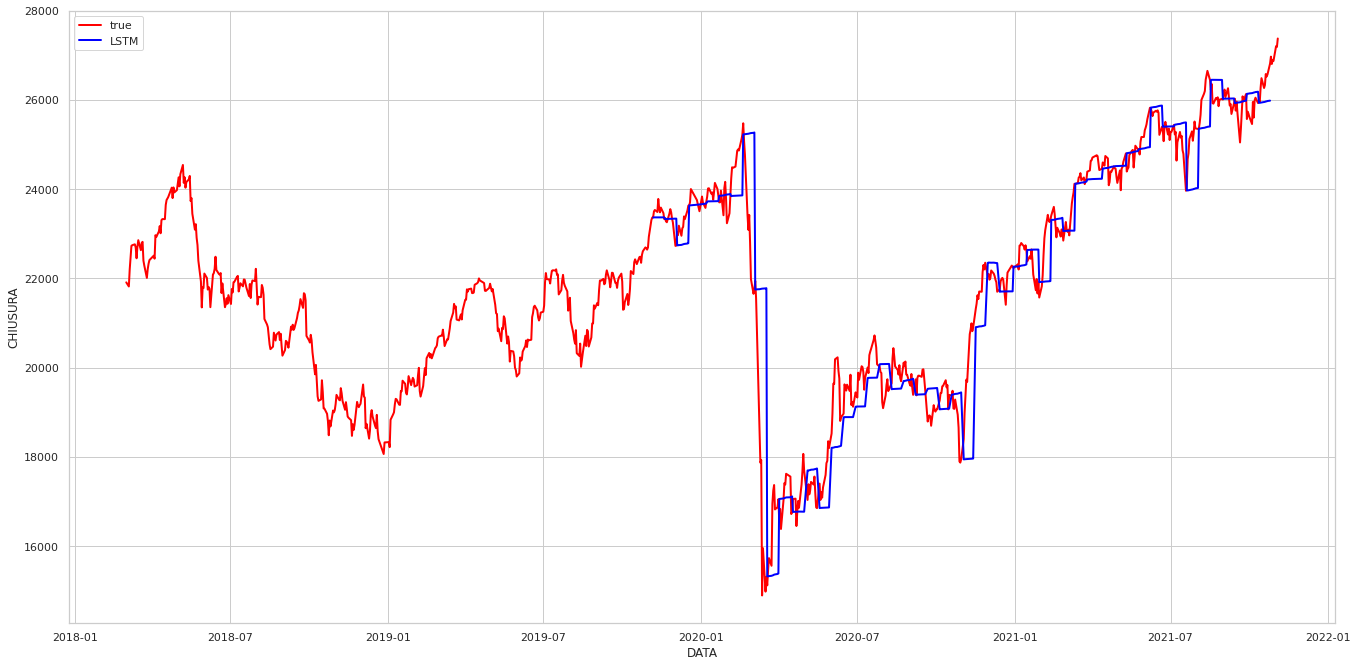

In [ ]:
y_prev_rnn_2=[]

i=0
while i<y_hat_rnn_2.shape[0]:
  p=y_hat_rnn_2[i,:]
  i+=n_output
  for z in p:
    y_prev_rnn_2.append(z)
y=dati_completi.CHIUSURA
x=dati_completi.index
x_prev=dati_completi.index[N_train:-(dati_completi.shape[0]-N_train-len(y_prev_rnn_2))]
p=sns.lineplot(x[1600:],y[1600:],color='red',lw=2,label='true')
p=sns.lineplot(x_prev,y_prev_rnn_2,color='blue',lw=2,label='LSTM')


# RNN DIFFERENZIATO CON DATI ESTERNI

In [ ]:
N=dati_completi.shape[0]
N_train=int(0.8*N)
n_output=10
n_timestamps=20

dati_y=dati_completi.iloc[:,9] #variabile target (la chiusura del FTSEMIB)
dati_X=dati_completi.iloc[:,[5,6,7,8,9]]


#Standardizziamo i dati utilizzando solo le osservazioni riservate all'addestramento
mu=dati_X[:N_train].mean()
sd=dati_X[:N_train].std()


#Dataframe dei predittori standardizzato
dati_X_sd=(dati_X-mu)/sd

X,y=data_to_supervised(dati_X_sd,dati_y,n_timestamps=n_timestamps,n_outputs=n_output)

X_train,y_train=X[:N_train-n_timestamps-n_output+1,:,:],y[:N_train-n_timestamps-n_output+1,:]

In [ ]:
input1 = Input(shape = (n_timestamps,dati_X.shape[1]))

# Layer LSTM sull'intero mese
z0 = LSTM(64,kernel_regularizer=regularizers.l2(0.001))(input1)

# Layer LSTM sulle medie settimanali
z1 = AveragePooling1D(pool_size=5, strides=5, padding='valid')(input1)
z1 = LSTM(32,kernel_regularizer=regularizers.l2(0.001))(z1)

# Layer LSTM sulle medie bisettimanali
z2 = AveragePooling1D(pool_size=10, strides=10, padding='valid')(input1)
z2 = LSTM(32,kernel_regularizer=regularizers.l2(0.001))(z2)

# Layer LSTM sulle medie trisettimanali
z3 = AveragePooling1D(pool_size=20, strides=15, padding='valid')(input1)
z3 = LSTM(32,kernel_regularizer=regularizers.l2(0.001))(z3)

# Valori medi delle variabili
z5 = GlobalAveragePooling1D()(input1)
z5 = Dense(16,activation='elu')(z5)

#Valori massimi delle variabili
z6 = GlobalMaxPooling1D()(input1)
z6 = Dense(16,activation='elu')(z6)

x = Concatenate()([z0,z1,z2,z3,z5,z6])
x = Dense(1024, activation = 'hard_sigmoid')(x)
x = Dropout(0.2,seed=12345)(x)

z = Dense(n_output, activation = "linear")(x)

output=Dense(n_output)(z)
model = Model(inputs=[input1], outputs=output)



optimizer = keras.optimizers.Adam()
model.compile(optimizer = optimizer , loss = "mse", metrics=["mae"])

In [ ]:
model.fit(X_train,
y_train,
epochs=20,
batch_size=256,
verbose=1)

Epoch 1/20
8/8 [==============================] - 8s 69ms/step - loss: 71513.8828 - mae: 198.6194
Epoch 2/20
8/8 [==============================] - 1s 66ms/step - loss: 71504.2188 - mae: 198.5923
Epoch 3/20
8/8 [==============================] - 1s 65ms/step - loss: 71499.1641 - mae: 198.5755
Epoch 4/20
8/8 [==============================] - 1s 65ms/step - loss: 71494.9062 - mae: 198.5632
Epoch 5/20
8/8 [==============================] - 1s 63ms/step - loss: 71495.2422 - mae: 198.5521
Epoch 6/20
8/8 [==============================] - 1s 65ms/step - loss: 71488.5312 - mae: 198.5457
Epoch 7/20
8/8 [==============================] - 1s 65ms/step - loss: 71475.9141 - mae: 198.5397
Epoch 8/20
8/8 [==============================] - 1s 64ms/step - loss: 71462.3750 - mae: 198.5311
Epoch 9/20
8/8 [==============================] - 1s 64ms/step - loss: 71446.8984 - mae: 198.5312
Epoch 10/20
8/8 [==============================] - 1s 65ms/step - loss: 71419.7266 - mae: 198.4932
Epoch 11/20
8/8 [==

In [ ]:
X_test,y_test=X[N_train-n_timestamps:,:,:],y[N_train-n_timestamps:,:]
X,y=data_to_supervised(dati_X,dati_completi.iloc[:,3], n_timestamps=0,n_outputs=n_output)
y_true=y[N_train:]
diff_pred_3=model.predict(X_test)
y_hat_rnn_3=diff_to_value(diff_pred_3)
mae_rnn_3=mae(y_hat_rnn_3,y_true)
mae_rnn_3

516.3628625528756

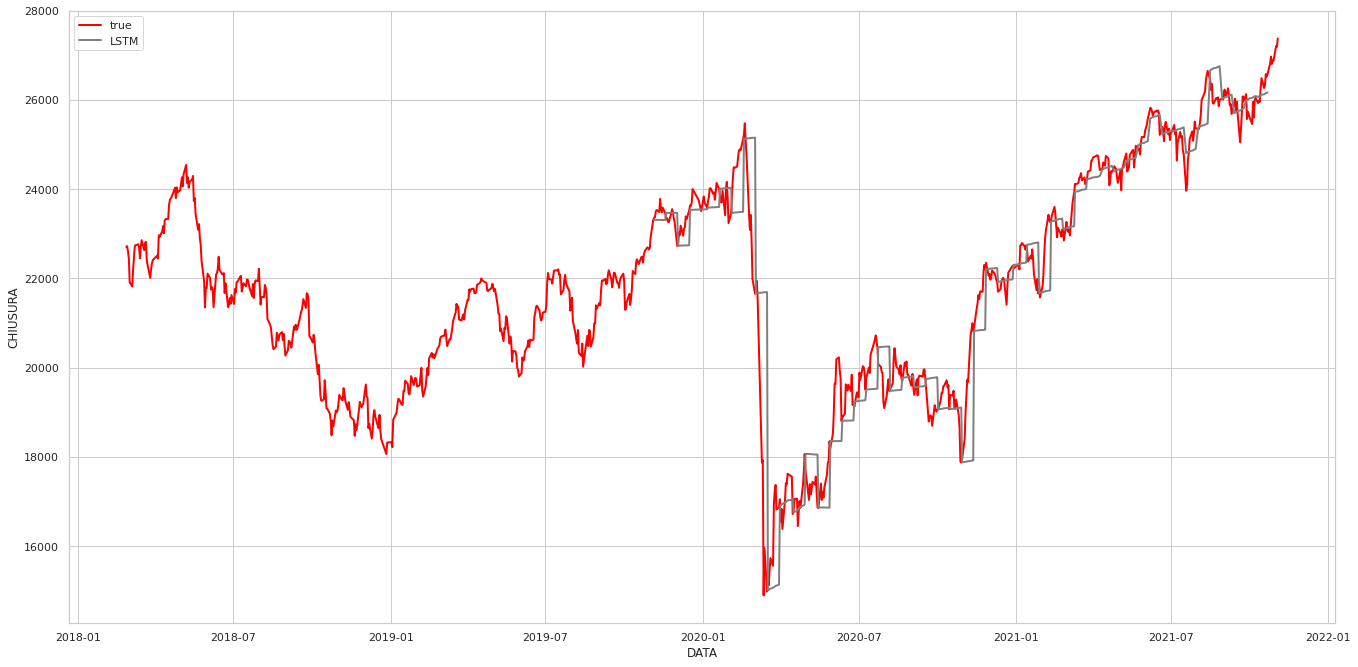

In [ ]:
y_prev_rnn_3=[]

i=0
while i<y_hat_rnn_3.shape[0]:
  p=y_hat_rnn_3[i,:]
  i+=n_output
  for z in p:
    y_prev_rnn_3.append(z)
y=dati_completi.CHIUSURA
x=dati_completi.index
x_prev=dati_completi.index[N_train:-(dati_completi.shape[0]-N_train-len(y_prev_rnn_3))]
p=sns.lineplot(x[1600:],y[1600:],color='red',lw=2,label='true')
p=sns.lineplot(x_prev,y_prev_rnn_3,color='grey',lw=2,label='LSTM')


# ARIMA

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=28422.166, Time=2.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28431.576, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28422.731, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28422.810, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28430.010, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=28426.733, Time=2.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=28426.732, Time=0.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=28424.069, Time=3.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=28424.042, Time=2.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28424.731, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=28428.357, Time=1.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=28428.093, Time=1.23 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=28423.782, Time=3.30 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=28420.514, Time=0.95 sec
 ARIMA(1,1,2)(0,0,0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

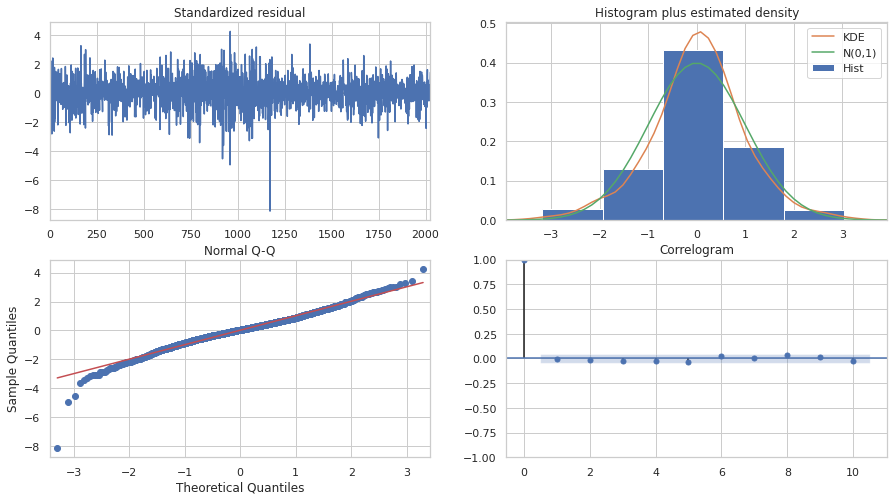

In [ ]:
chiusure=np.array(dati_completi.iloc[:,3])
y_train_arima=chiusure[:N_train] #Serie da utilizzare per selezionare l'ordine e stimare i coefficienti.

#La selezione dell'ordine sarà automaticamente gestita dalla funzione autoARIMA che mostrerà il valore dell'ordine che minimizzerà il criterio AIC
model_autoARIMA = auto_arima(y_train_arima,trace=True,max_order=20,step_wise=False,max_p=10,max_q=10)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
from google.colab import files
plt.savefig("STEPWISE.png")
files.download("STEPWISE.png")
plt.show()

L'ordine ottimale è considerato il (2,1,2).
Stimiamo quindi i parametri del modello ARIMA(2,1,2) sulla serie fino alla N_train osservazione (y_train_arima).

In [ ]:
order=(2,1,2)
arima_model=ARIMA(y_train_arima,order=order)
param_value=arima_model.fit(return_params=True)#
param_key=arima_model.param_names
param={} #In questo dizionario conterremo i coefficienti stimati
for i in range(len(param_key)):
  param[param_key[i]]=param_value[i]
param

{'ar.L1': -0.4197137800017165,
 'ar.L2': -0.6754875196163701,
 'ma.L1': 0.35228049301196995,
 'ma.L2': 0.6695052504409039,
 'sigma2': 71390.23387771324}

Calcoliamo le previsioni del modello ARIMA tramite la funzione previsioni_arima (il cui funzionamento è spiegato nella prima sezione)

In [ ]:
y_hat_arima=previsioni_arima(chiusure,N_train-1,n_output,order,param)

In [ ]:
dati_y=dati_completi.iloc[:,3]
dati_X=dati_completi.iloc[:,[3]] # in questo caso sono inutili

#Utilizziamo data_to_supervised per creare i blocchi di 10 osservazioni rispetto ai quali calcolare l'errore assoluto medio delle previsioni
#del modello ARIMA.
X,y=data_to_supervised(dati_X,dati_y, n_timestamps=0,n_outputs=n_output)
y_true=y[N_train:]
print('il primo blocco di predizioni sarà: {}'.format(y_true[0].tolist()))

il primo blocco di predizioni sarà: [23364.82, 23373.22, 23503.03, 23534.49, 23489.93, 23782.15, 23578.43, 23481.35, 23588.59, 23463.98]


Calcoliamo l'errore assoluto medio

In [ ]:
mae_arima=mae(y_true,y_hat_arima)
mae_arima

577.5841819300476

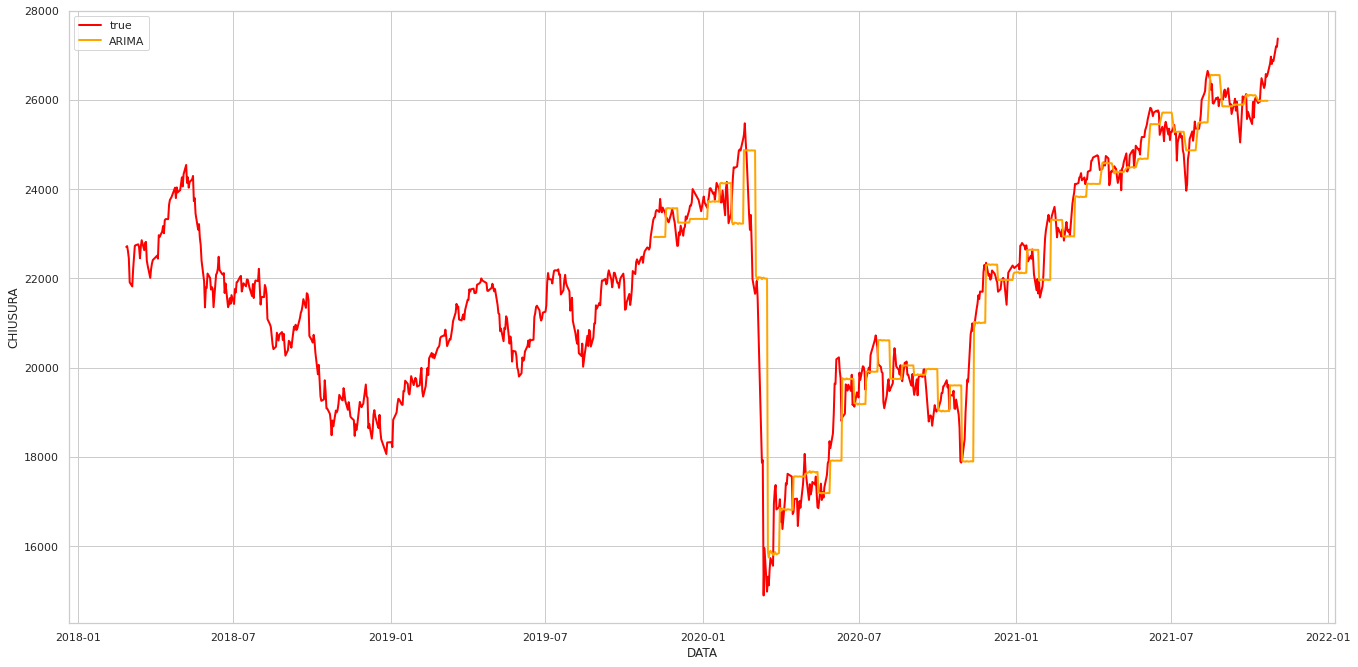

In [ ]:
y_prev_arima=[]

i=0
while i<y_hat_arima.shape[0]:
  p=y_hat_arima[i,:]
  i+=n_output
  for z in p:
    y_prev_arima.append(z)
y=dati_completi.CHIUSURA
x=dati_completi.index
x_prev=dati_completi.index[N_train:-(dati_completi.shape[0]-N_train-len(y_prev_arima))]
p=sns.lineplot(x[1600:],y[1600:],color='red',lw=2,label='true')
p=sns.lineplot(x_prev,y_prev_arima,color='orange',lw=2,label='ARIMA')

# RNN Orizzonte 1

In [ ]:
N=dati_completi.shape[0]
N_train=int(0.8*N)
n_output=1
n_timestamps=20

dati_y=dati_completi.iloc[:,9] #variabile target (la chiusura del FTSEMIB)
dati_X=dati_completi.iloc[:,[5,6,7,8,9]]


#Standardizziamo i dati utilizzando solo le osservazioni riservate all'addestramento
mu=dati_X[:N_train].mean()
sd=dati_X[:N_train].std()


#Dataframe dei predittori standardizzato
dati_X_sd=(dati_X-mu)/sd

X,y=data_to_supervised(dati_X_sd,dati_y,n_timestamps=n_timestamps,n_outputs=n_output)

X_train,y_train=X[:N_train-n_timestamps-n_output+1,:,:],y[:N_train-n_timestamps-n_output+1,:]

In [ ]:
input1 = Input(shape = (n_timestamps,dati_X.shape[1]))

# Layer LSTM sull'intero mese
z0 = LSTM(64,kernel_regularizer=regularizers.l2(0.001))(input1)

# Layer LSTM sulle medie settimanali
z1 = AveragePooling1D(pool_size=5, strides=5, padding='valid')(input1)
z1 = LSTM(32,kernel_regularizer=regularizers.l2(0.001))(z1)

# Layer LSTM sulle medie bisettimanali
z2 = AveragePooling1D(pool_size=10, strides=10, padding='valid')(input1)
z2 = LSTM(32,kernel_regularizer=regularizers.l2(0.001))(z2)

# Layer LSTM sulle medie trisettimanali
z3 = AveragePooling1D(pool_size=20, strides=15, padding='valid')(input1)
z3 = LSTM(32,kernel_regularizer=regularizers.l2(0.001))(z3)

# Valori medi delle variabili
z5 = GlobalAveragePooling1D()(input1)
z5 = Dense(16,activation='elu')(z5)

#Valori massimi delle variabili
z6 = GlobalMaxPooling1D()(input1)
z6 = Dense(16,activation='elu')(z6)

x = Concatenate()([z0,z1,z2,z3,z5,z6])
x = Dense(1024, activation = 'hard_sigmoid')(x)
x = Dropout(0.2,seed=12345)(x)

z = Dense(n_output, activation = "linear")(x)

output=Dense(n_output)(z)
model = Model(inputs=[input1], outputs=output)



optimizer = keras.optimizers.Adam()
model.compile(optimizer = optimizer , loss = "mse", metrics=["mae"])

In [ ]:
model.fit(X_train,
y_train,
epochs=15,
batch_size=256,
verbose=1)

Epoch 1/15
8/8 [==============================] - 7s 66ms/step - loss: 71625.7578 - mae: 198.8337
Epoch 2/15
8/8 [==============================] - 0s 62ms/step - loss: 71618.8750 - mae: 198.8223
Epoch 3/15
8/8 [==============================] - 1s 65ms/step - loss: 71617.4609 - mae: 198.8088
Epoch 4/15
8/8 [==============================] - 1s 63ms/step - loss: 71611.7422 - mae: 198.8006
Epoch 5/15
8/8 [==============================] - 1s 63ms/step - loss: 71610.8438 - mae: 198.7950
Epoch 6/15
8/8 [==============================] - 0s 62ms/step - loss: 71601.2578 - mae: 198.7829
Epoch 7/15
8/8 [==============================] - 1s 63ms/step - loss: 71599.4766 - mae: 198.7783
Epoch 8/15
8/8 [==============================] - 0s 62ms/step - loss: 71587.7266 - mae: 198.7634
Epoch 9/15
8/8 [==============================] - 1s 66ms/step - loss: 71578.7109 - mae: 198.7480
Epoch 10/15
8/8 [==============================] - 1s 63ms/step - loss: 71575.2031 - mae: 198.7503
Epoch 11/15
8/8 [==

In [ ]:
X_test,y_test=X[N_train-n_timestamps:,:,:],y[N_train-n_timestamps:,:]
X,y=data_to_supervised(dati_X,dati_completi.iloc[:,3], n_timestamps=0,n_outputs=n_output)
y_true=y[N_train:]
diff_pred_4=model.predict(X_test)
y_hat_rnn_4=diff_to_value(diff_pred_4)
mae_rnn_4=mae(y_hat_rnn_4,y_true)
mae_rnn_4

218.35529844126532

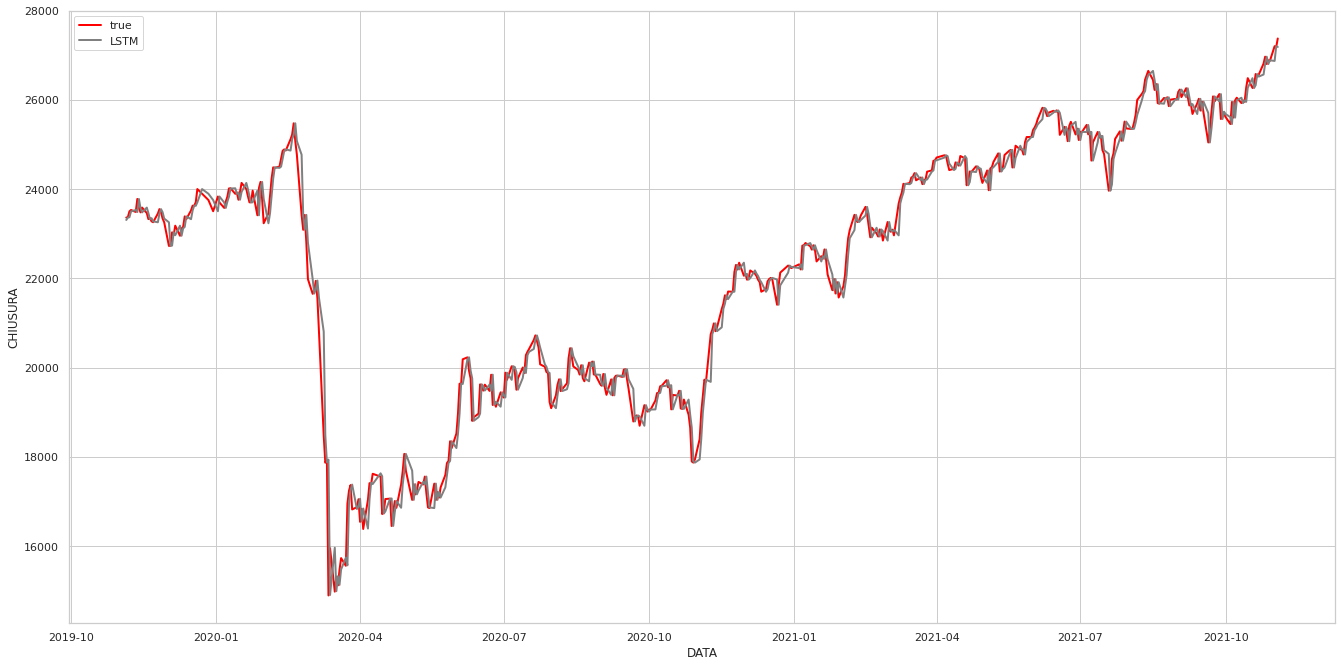

In [ ]:
y_prev_rnn_4=y_hat_rnn_4.reshape(y_hat_rnn_4.shape[0])
y=dati_completi.CHIUSURA
x=dati_completi.index
p=sns.lineplot(x[-y_hat_rnn_4.shape[0]:],y[-y_hat_rnn_4.shape[0]:],color='red',lw=2,label='true')
p=sns.lineplot(x[-y_hat_rnn_4.shape[0]:],y_prev_rnn_4,color='grey',lw=2,label='LSTM')

# ARIMA Orizzonte 1

In [ ]:
n_output=1
y_hat_arima_2=previsioni_arima(chiusure,N_train-1,n_output,order,param)

In [ ]:
dati_y=dati_completi.iloc[:,3]
dati_X=dati_completi.iloc[:,[3]] # in questo caso sono inutili

#Utilizziamo data_to_supervised per creare i blocchi di 10 osservazioni rispetto ai quali calcolare l'errore assoluto medio delle previsioni
#del modello ARIMA.
X,y=data_to_supervised(dati_X,dati_y, n_timestamps=0,n_outputs=n_output)
y_true=y[N_train:]
print('il primo blocco di predizioni sarà: {}'.format(y_true[0].tolist()))

il primo blocco di predizioni sarà: [23364.82]


Calcoliamo l'errore assoluto medio

In [ ]:
mae_arima_2=mae(y_true,y_hat_arima_2)
mae_arima_2

309.26161415523546

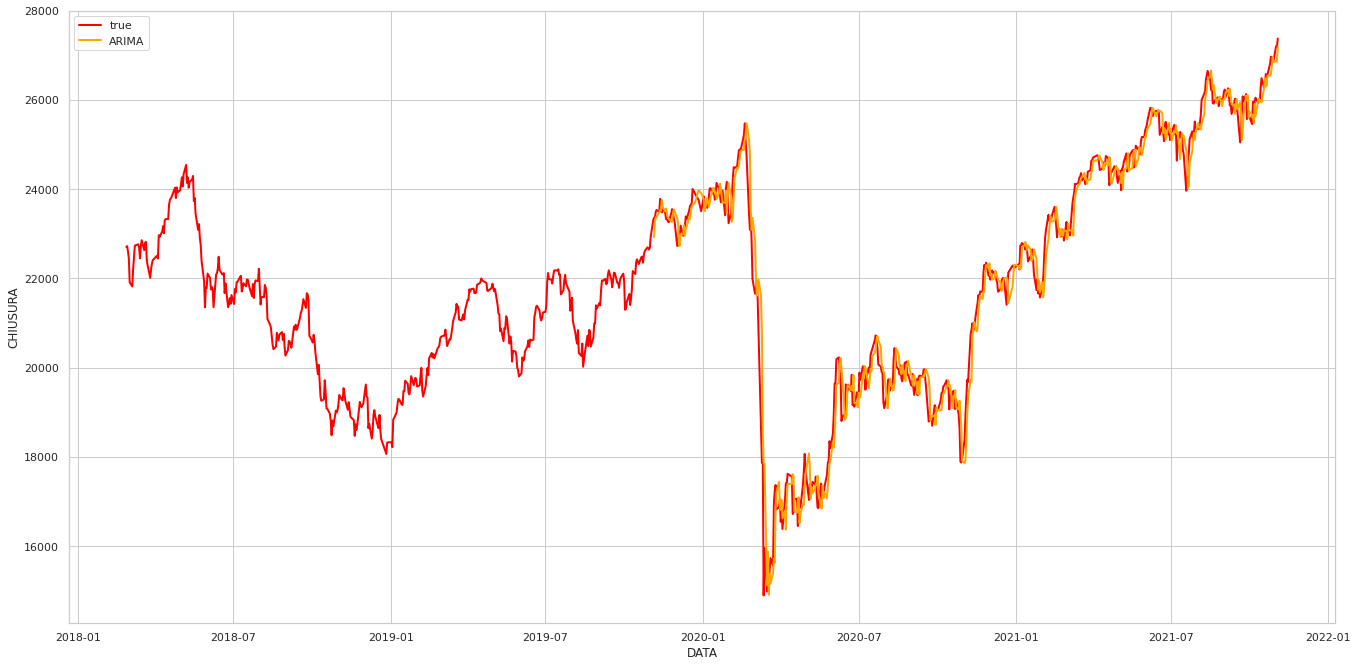

In [ ]:
y_prev_arima_2=y_hat_arima_2.reshape(y_hat_arima_2.shape[0])
y=dati_completi.CHIUSURA
x=dati_completi.index
x_prev=dati_completi.index[N_train:-(dati_completi.shape[0]-N_train-len(y_prev_arima_2))]
p=sns.lineplot(x[1600:],y[1600:],color='red',lw=2,label='true')
p=sns.lineplot(x[-y_hat_arima_2.shape[0]:],y_prev_arima_2,color='orange',lw=2,label='ARIMA')


# Confronto

In [ ]:
print('Errore di Previsione negli RNN:')
print(mae_rnn_1)
print(mae_rnn_2)
print(mae_rnn_3)
print(mae_rnn_4)

print('Errore di Previsione negli ARIMA:')
print(mae_arima)
print(mae_arima_2)

Errore di Previsione negli RNN:
1577.313164970567
517.977216878104
516.3628625528756
218.35529844126532
Errore di Previsione negli ARIMA:
577.5841819300476
309.26161415523546


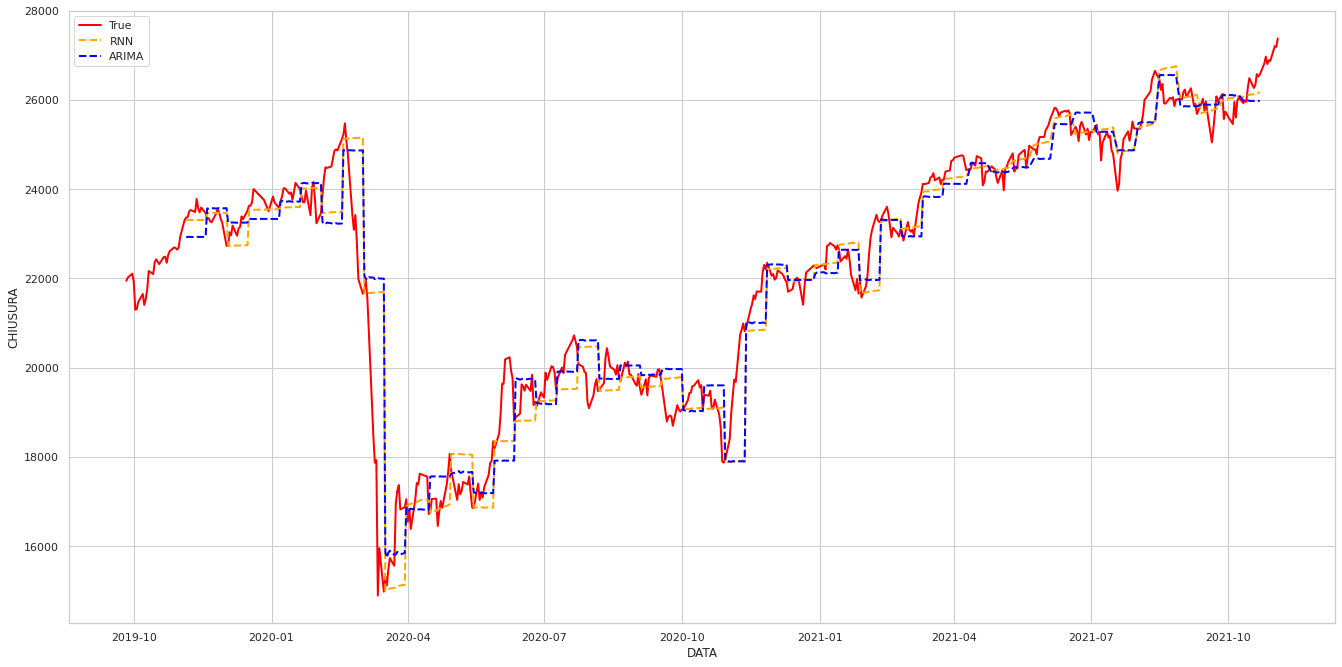

In [ ]:
y=dati_completi.CHIUSURA
x=dati_completi.index

x_prev=dati_completi.index[N_train:-(dati_completi.shape[0]-N_train-len(y_prev_rnn_3))]
p=sns.lineplot(x[2000:],y[2000:],color='red',lw=2,label='True')
p=sns.lineplot(x_prev,y_prev_rnn_3,color='orange',lw=2,label='RNN',linestyle='--')
p=sns.lineplot(x_prev,y_prev_arima,color='blue',lw=2,label='ARIMA',linestyle='--')